In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
# %pylab inline

In [3]:
qick_path = "/home/xilinx/jupyter_notebooks/fw/2024-06-14_4x2_commonclk-4pt9/qick_4x2.bit"

bitfile=qick_path

In [4]:
soc = QickSoc(bitfile=qick_path)
soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.291

Firmware configuration (built Fri Jun 14 18:17:46 2024):

	Global clocks (MHz): tProcessor 307.200, RF reference 409.600

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 1024 decimated (3.333 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 1024 decimated (3.333 us)
		triggered by out

In [5]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        
        self.declare_readout(ch=self.cfg['ro_chs'][0], length=self.cfg['readout_length'], freq=0, sel='input')
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=self.ro_chs, 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.synci(int(self.cfg['readout_length'] * 1.25))
        self.wait_all(self.cfg['relax_delay'])

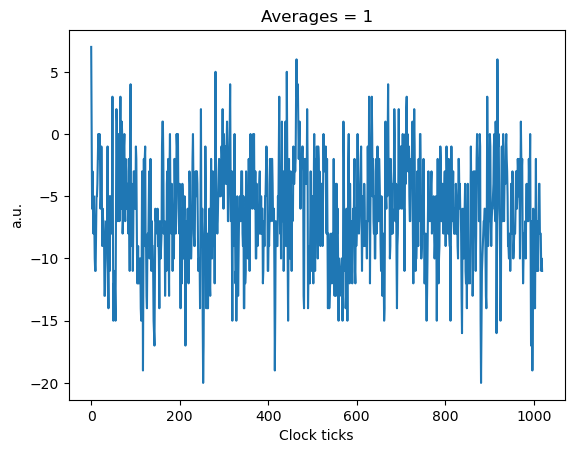

In [6]:
config={"ro_chs":[1], # --Fixed
        "reps": 1,
        "relax_delay":3000, # --us        
        "readout_length":1020, # [Clock ticks]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":1
       }

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)

data = iq_list[0][0]

# Plot results.
plt.figure(1)
plt.plot(data)
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))

x0, _  = find_peaks(data,height=500)
plt.scatter(x0, data[x0], c='red')

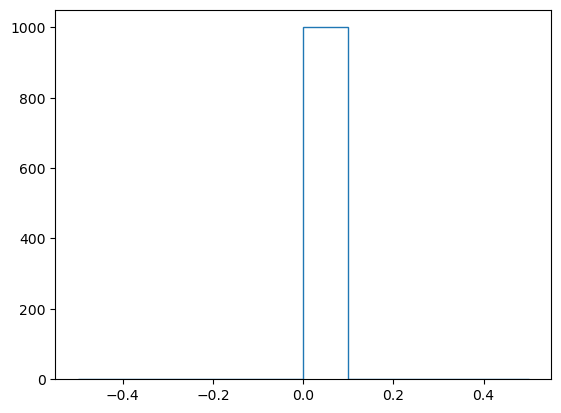

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

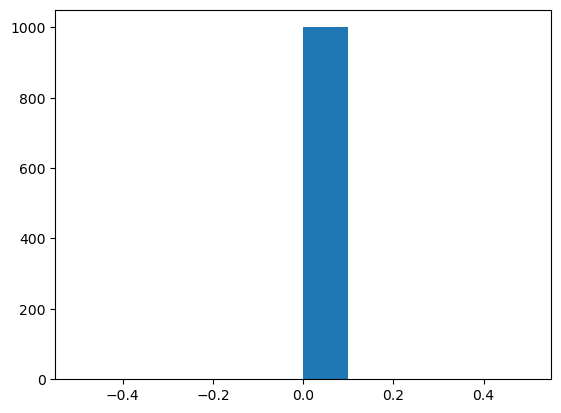

In [7]:
config={"ro_chs":[1], # --Fixed
        "reps": 1,
        "relax_delay":3000, # --us        
        "readout_length":1020, # [Clock ticks]
        "adc_trig_offset": 100, # [Clock ticks]
        "soft_avgs":1
       }

n = []

for i in range(1000):

    prog =LoopbackProgram(soccfg, config)
    iq_list = prog.acquire_decimated(soc, progress=False)

    data = iq_list[0][0]
    x0, _  = find_peaks(data,height=500)
    n.append(len(x0))
counts, bins = np.histogram(n)
plt.stairs(counts, bins)
plt.show()
plt.hist(bins[:-1], bins, weights=counts)

In [8]:
np.uint32(2**32//2), np.uint32(2**32//2)

(2147483648, 2147483648)

[array([[[0, 0]],

       [[0, 0]],

       [[0, 0]],

       ...,

       [[0, 0]],

       [[0, 0]],

       [[0, 0]]])]


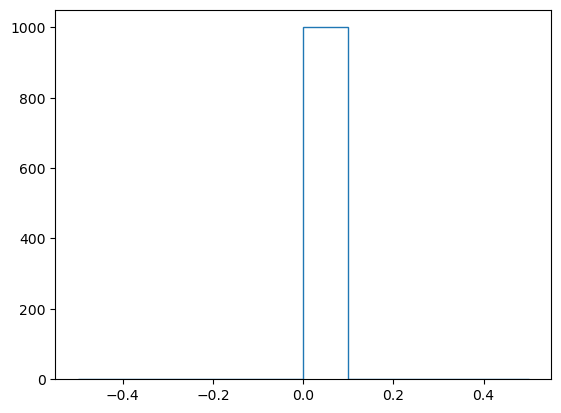

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

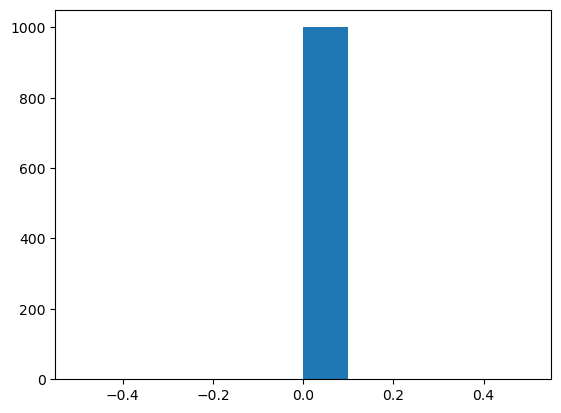

In [101]:
config['reps'] = 1000
config['readout_length'] = 1020
prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_counted(soc, high_threshold=10000, low_threshold=0, progress=False)
print(iq_list)
data = np.array([a[0][0] for a in iq_list[0]])

counts, bins = np.histogram(data)
plt.stairs(counts, bins)
plt.show()
plt.hist(bins[:-1], bins, weights=counts)


In [10]:
prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, progress=False)
print((np.array(iq_list)/config['readout_length']).astype(float))

[[[[-6.31862745  0.        ]]

  [[-6.4754902   0.        ]]

  [[-6.09509804  0.        ]]

  ...

  [[-5.97254902  0.        ]]

  [[-6.13921569  0.        ]]

  [[-5.60392157  0.        ]]]]


In [11]:
print(prog.asm())


// Program

        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 999;
LOOP_J: regwi 0, $16, 32768;                    //out = 0b1000000000000000
        seti 7, 0, $16, 100;                    //ch =0 out = $16 @t = 0
        seti 7, 0, $0, 110;                     //ch =0 out = 0 @t = 0
        synci 1275;
        waiti 0, 4120;
        mathi 0, $15, $15 + 1;
        memwi 0, $15, 1;
        loopnz 0, $14, @LOOP_J;
        end ;


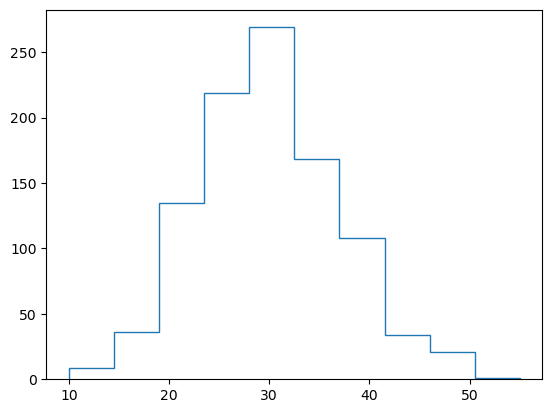

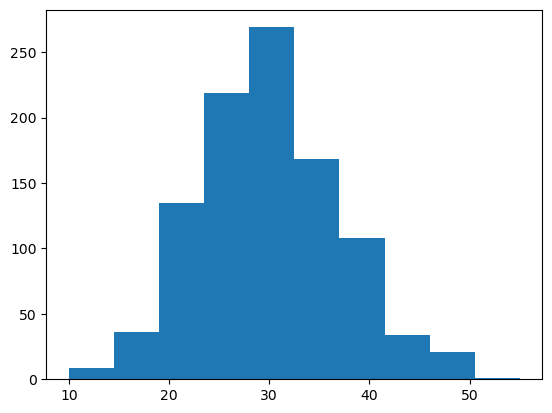

In [178]:
config['reps'] = 1000
config['readout_length'] = 1020
prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_counted(soc, high_threshold=10000, low_threshold=1, progress=False)
data = iq_list[0][:,0,0]

counts, bins = np.histogram(data)
plt.stairs(counts, bins)
plt.show()
plt.hist(bins[:-1], bins, weights=counts);


In [152]:
config['reps'] = 1000
config['readout_length'] = 10200
prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_counted(soc, high_threshold=10000, low_threshold=1, progress=False)
data = iq_list[0][:,0,0]

data.mean()

305.895

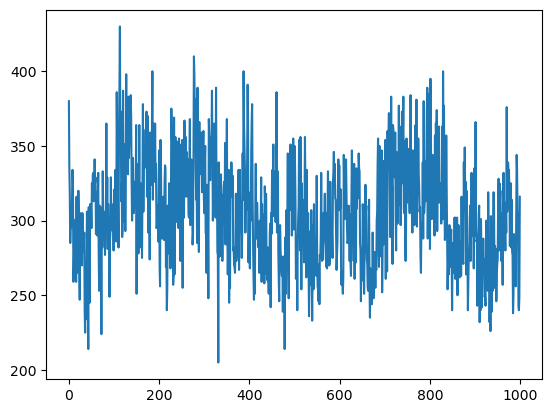

In [153]:
plt.plot(data)

In [174]:
thresh_h = 5
thresh_l = 1
config['reps'] = 1
config['readout_length'] = 1020
prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, edge_counting=True, high_threshold=thresh_h, low_threshold=thresh_l, progress=False)
samples = iq_list[0][0]
counts = soc.avg_bufs[1].transfer_avg(0,1)[0][0]
# print(samples, counts)

h_state = False
edges = []
for i, sample in enumerate(samples):
    last_state = h_state
    if sample > thresh_h:
        h_state = True
    elif sample < thresh_l:
        h_state = False
    if h_state and not last_state:
        edges.append(i)
# data = np.array([a[0][0] for a in iq_list[0]])
print("firmware count=%d, software count=%d"%(counts, len(edges)))

firmware count=21, software count=5


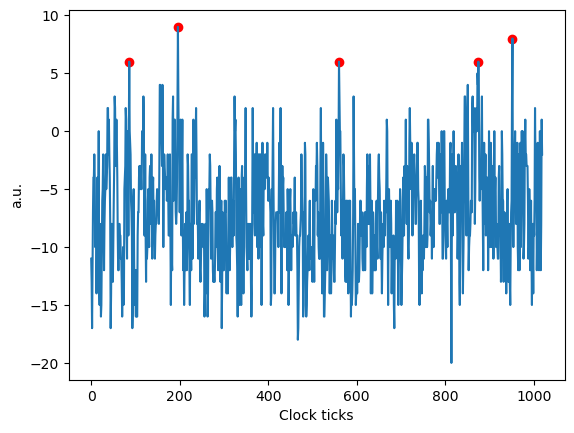

In [175]:
# Plot results.
plt.figure(1)
plt.plot(samples)
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")

# x0, _  = find_peaks(data,height=500)
plt.scatter(edges, samples[edges], c='red')

In [177]:
print(soc.avg_bufs[1].avg_photon_mode_reg)
print(soc.avg_bufs[1].avg_l_threshold_reg)
print(soc.avg_bufs[1].avg_h_threshold_reg)
print(soc.avg_bufs[1].transfer_avg(0,1)[0][0])
print(np.array(soc.avg_bufs[1].mmio.array[:16]))

1
1
5
21
[   1    0 1020    0    0    2    1    0 1020    0 1022 1022    1    5
    1    0]
